# 🌪️ Lorenz 80 

## 📝 General description

This code implements the numerical simulations of the article _Attractor Sets and Quasi-Geostrophic Equilibrium_ by E.D. Lorenz (1980), which explores the dynamics of atmospheric systems using two models: the Primitive Equations (PE) and its Quasi-Geostrophic approximation (QG). 

The work seeks to reproduce the original results of the article, simulate attractors formed by the dynamic systems and make a comparison between the PE and QG models. The simulations use the fourth-order Runge-Kutta numerical method to solve the systems of differential equations.

## 📦 Libraries used

The code uses the `NumPy` libraries for mathematical operations and manipulating arrays, and `Matplotlib` for visualizing and plotting graphs.

## 🔢 Vectors and constants

All vectors and constants were defined following section 04, _Choice of numerical values_ of the article [1], except for the first element of the force vector $F$, i.e., $F_1$. For the simulations, $F_1 = 0.1$. This value is defined in section 05, _Behavior of the model_ of the same article [1].

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

vector_a = [1, 1, 3]
vector_b = [
    0.5 * (vector_a[0] - vector_a[1] - vector_a[2]),
    0.5 * (vector_a[1] - vector_a[2] - vector_a[0]),
    0.5 * (vector_a[2] - vector_a[0] - vector_a[1]),
]
c = np.sqrt(3 / 4)

f_inv = 10800
vector_h = [-1, 0, 0]
vector_f = [0.1, 0, 0]
g_0 = 8
kappa_0 = 1 / 48
nu_0 = kappa_0
rtol_value = 10**(-8)
atol_value = 10**(-10)


## 🌀 PE Model

The `pe_model()` function is a reproduction of equations (33-35) from the article [1]. They are:

$a_i\frac{dx_i}{d\tau} = a_ib_ix_ix_k - c(a_i - a_k)x_iy_k  + c(a_i - a_j)y_ix_k -2c^2y_iy_k - \nu_0a_i^2x_i + a_iy_i - a_iz_i$

$ a_i\frac{dy_i}{d\tau} = -a_ib_kx_iy_k - a_ib_iy_ix_k + c(a_k - a_i)y_iy_k - a_ix_i - \nu_0a_i^2y_i$

$\frac{dz_i}{d\tau} = -b_kx_i(z_k - h_k) - b_i(z_i - h_i)x_k + cy_i(z_k - h_k) - c(z_i - h_i)y_k + g_0a_ix_i - \kappa_0a_iz_i + F_i$ 

### Discretization method

The discretization method applied by the `runge_kutta_pe()` function was the RK44 presented in [2]:

$\Phi(t, y, h) = \frac{1}{6}(\kappa_1 + 2\kappa_2 + 2\kappa_3 + \kappa_4)$ 

$\begin{cases}
\kappa_1 = f(t, y) \\
\kappa_2 = f(t + h/2, y + (h/2)\kappa_1) \\
\kappa_3 = f(t + h/2, y + (h/2)\kappa_2) \\
\kappa_4 = f(t + h, y + h\kappa_3)
\end{cases}$

In [2]:
def pe_model(state, t):
    x = state[0:3]
    y = state[3:6]
    z = state[6:9]

    dx = np.zeros(3)
    dy = np.zeros(3)
    dz = np.zeros(3)

    for i in range(3):
        j = (i + 1) % 3
        k = (i + 2) % 3

        dx[i] = (
            vector_a[i] * vector_b[i] * x[j] * x[k]
            - c * (vector_a[i] - vector_a[k]) * x[j] * y[k]
            + c * (vector_a[i] - vector_a[k]) * x[j] * y[k]
            - c * (vector_a[i] - vector_a[j]) * y[j] * x[k]
            - 2 * c**2 * y[i] * y[k]
            - nu_0 * vector_a[i] ** 2 * x[i]
            + vector_a[i] * y[i]
            - vector_a[i] * z[i]
        ) / vector_a[i]

        dy[i] = (
            -vector_a[k] * vector_b[k] * x[j] * y[k]
            - vector_a[j] * vector_b[j] * y[j] * x[k]
            + c * (vector_a[k] - vector_a[j]) * y[j] * y[k]
            - vector_a[i] * x[i]
            - nu_0 * vector_a[i] ** 2 * y[i]
        ) / vector_a[i]

        dz[i] = (
            -vector_b[k] * x[j] * (z[k] - vector_h[k])
            - vector_b[j] * (z[j] - vector_h[j]) * x[k]
            + c * y[j] * (z[k] - vector_h[k])
            - c * (z[j] - vector_h[j]) * y[k]
            + g_0 * vector_a[i] * x[i]
            - kappa_0 * vector_a[i] * z[i]
            + vector_f[i]
        )
    return np.concatenate([dx, dy, dz])


def runge_kutta_pe(x_initial, y_initial, z_initial, days):
    initial_state = np.concatenate([x_initial, y_initial, z_initial])
    t_final = days * 8
    n_steps = int(t_final * 24)
    t = np.linspace(0, t_final, n_steps)

    solution = odeint(pe_model, initial_state, t, rtol=rtol_value, atol=atol_value)

    return t / 8, solution[:, :3], solution[:, 3:6], solution[:, 6:]


## 🌊 QG model

The `qg_model()` function is a reproduction of equation (43) from the article [1], shown below:

$(a_ig_0 + 1)\frac{dy_i}{d\tau} = g_0c(a_k - a_j)y_jy_k - a_i(a_ig_0v_0 + \kappa_0)y_i - ch_ky_j + ch_jy_k + F_i$ 

### Discretization method

Like the PE model, the QG model also used the RK44 method from reference [2]

In [3]:
def qg_model(y, t):
        dy = np.zeros(3)
        for i in range(3):
            j = (i + 1) % 3
            k = (i + 2) % 3
            dy[i] = (
                g_0 * c * (vector_a[k] - vector_a[j]) * y[j] * y[k]
                - vector_a[i] * (vector_a[i] * g_0 * nu_0 + kappa_0) * y[i]
                - c * vector_h[k] * y[j]
                + c * vector_h[j] * y[k]
                + vector_f[i]
            ) / (vector_a[i] * g_0 + 1)
        return dy

def runge_kutta_qg(y0, total_days):    
    t = np.arange(0, total_days)
    
    solution = odeint(qg_model, y0, t, rtol=rtol_value, atol=atol_value)
    
    return t, solution

## 📊 Visualization of Results

This study used three different approaches to data visualization:

1. **Temporal Evolution of Primary Indices**

   In this visualization, we follow the behavior of the variables $x_1$, $y_1$ and $z_1$ over time. This representation was chosen to allow a direct comparison with Figure 1 presented in the reference article [1].

2. **Behavior of the y-vector**

   This visualization shows how the three components of the $y$ vector ($y_1$, $y_2$ and $y_3$) evolve simultaneously. Although this representation does not appear directly in the main references, it was fundamental for comparing the PE and QG models, based on the equivalence described in the final paragraphs of page 1692 of the article [1].

3. **Two-dimensional projections of the y-vector**

   This visualization shows the system's attractor through three two-dimensional projections: $y_1 \times y_1$, $y_3 \times y_2$ and $y_1 \times y_3$. These projections were chosen to validate our results by comparing them with the attractors presented in the article [3].

In [4]:
def evolution_x1y1z1(time, x, y, z, days):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(time, x[:, 0], "-", linewidth=1.5, label="x1", color="green")
    ax.plot(time, y[:, 0], "-", linewidth=1.5, label="y1", color="blue")
    ax.plot(time, z[:, 0], "-", linewidth=1.5, label="z1", color="red")

    ax.set_xlim(0, days)
    ax.set_ylim(-0.4, 0.6)
    ax.set_xlabel("Days")
    ax.grid(True)
    ax.legend()

    return fig, ax


def plot_evolution_y(time, y, days):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(time, y[:, 0], "-", linewidth=2, label="y1", color="green")
    ax.plot(time, y[:, 1], "-", linewidth=2, label="y2", color="blue")
    ax.plot(time, y[:, 2], "-", linewidth=2, label="y3", color="red")

    ax.set_xlim(0, days)
    ax.set_ylim(-0.1, 0.6)
    ax.set_xlabel("Days")
    ax.grid(True)
    ax.legend()

    return fig, ax


def plot_y2y3(y):
    plt.figure(figsize=(12, 4))
    plt.plot(y[:, 2], y[:, 1], "r-", linewidth=1.5)
    plt.xlabel("y3")
    plt.ylabel("y2")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.title("L80 Attractor")

    plt.xlim(-0.3, 0.3)
    plt.ylim(-0.5, 0.5)


def plot_y1y3(y):
    plt.figure(figsize=(12, 4))
    plt.plot(y[:, 0], y[:, 2], "r-", linewidth=1.5)
    plt.xlabel("y1")
    plt.ylabel("y3")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.title("L80 Attractor")

    plt.xlim(-0.3, 0.6)
    plt.ylim(-0.3, 0.3)


def plot_y3y1(y):
    plt.figure(figsize=(12, 4))
    plt.plot(y[:, 2], y[:, 0], "r-", linewidth=1.5)
    plt.xlabel("y3")
    plt.ylabel("y1")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.title("L80 Attractor")

    plt.ylim(-0.25, 0.5)
    plt.xlim(-0.25, 0.25)

## 🔬 Simulations

The simulations are divided into three parts based on the different initial conditions:

### Standard condition

In this simulation, we reproduced figure 1 from the article [1] to observe the temporal evolution of the variables x_1, y_1 and z_1. Given the following initial condition:

$x_1 = y_1 = z_1 = 0.1$

$x_2 = x_3 = y_2 = y_3 = z_2 = z_3 = 0$

### Hadley conditions 01

According to [4], the Hadley conditions can be applied to the PE Model using the following values:

$x_1 = -v_0a_1y_1$

$y_1 = F_1/a_1v_0(1 + a_1g_0 + v_0^2a_1^2)$

$z_1 = (1 + v_0^2a_1^2)y_1$

$x_2 = x_3 = y_2 = y_3 = z_2 = z_3 = 0$

This simulation allows us to study the attractors generated by the PE model.

### Hadley conditions 02

According to the article [1], we can simulate Hadley conditions using the following initial conditions:

$x_1 = -0.01111$

$y_1 = 0.53331$

$z_1 = 0.53354$

$x_2 = x_3 = y_2 = y_3 = z_2 = z_3 = 0$

These values are equivalent to the QG model when:

$y_1 = 0.53333$ e $y_2 = y_3 = 0$

In this simulation, we compare the PE and QG models.

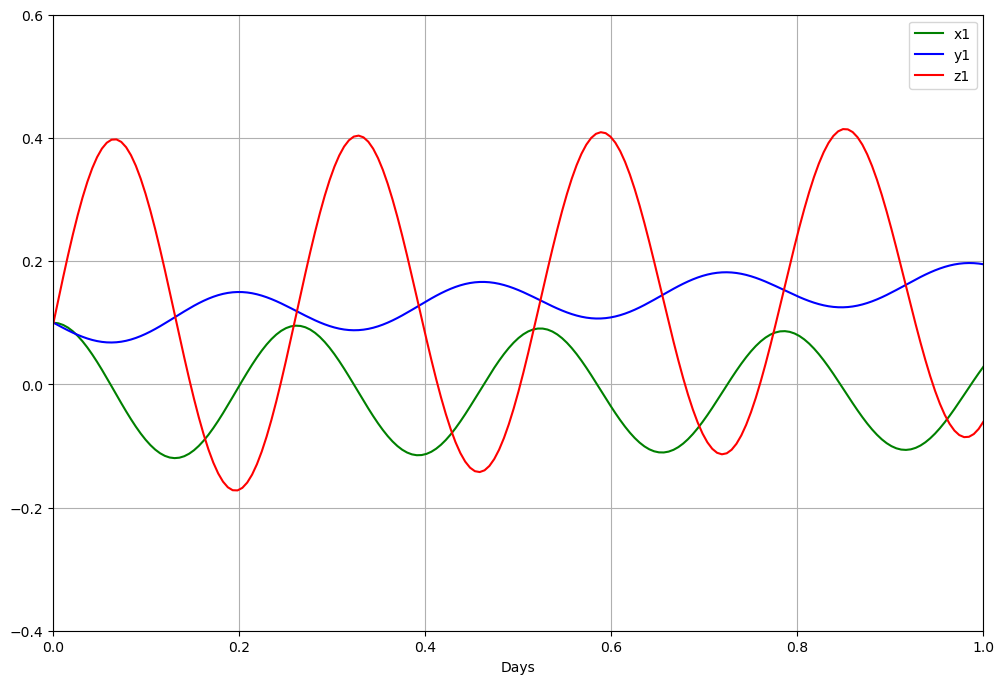

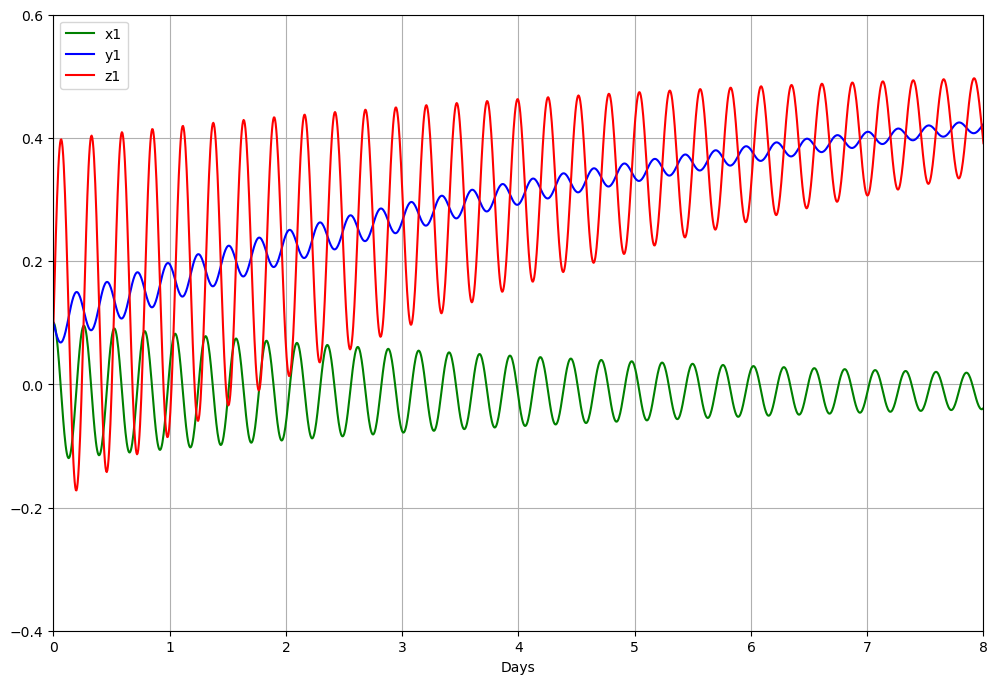

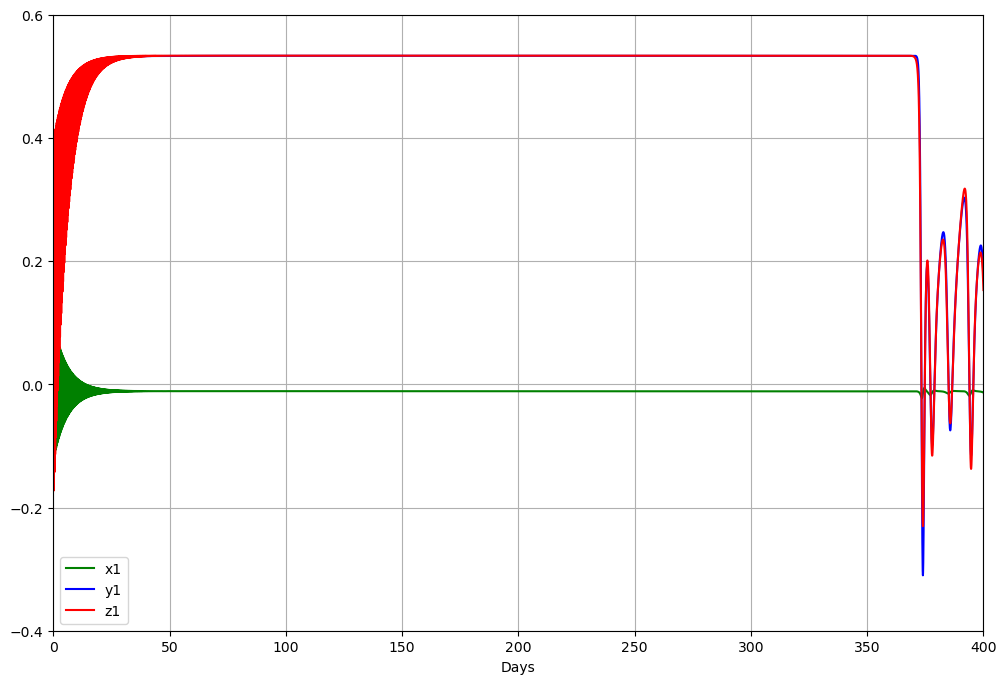

In [5]:
# SIMULATION STANDARD CONDITIONS - FIGURE 1

# Simulation days
total_days = 400

# Initial conditions
x0 = [0.1, 0, 0]
y0 = [0.1, 0, 0]
z0 = [0.1, 0, 0]

# PE model simulation
t_fig1, x_fig1, y_fig1, z_fig1 = runge_kutta_pe(x0, y0, z0, total_days)

# Plot
evolution_x1y1z1(t_fig1, x_fig1, y_fig1, z_fig1, 1)
evolution_x1y1z1(t_fig1, x_fig1, y_fig1, z_fig1, 8)
evolution_x1y1z1(t_fig1, x_fig1, y_fig1, z_fig1, total_days)
plt.show()

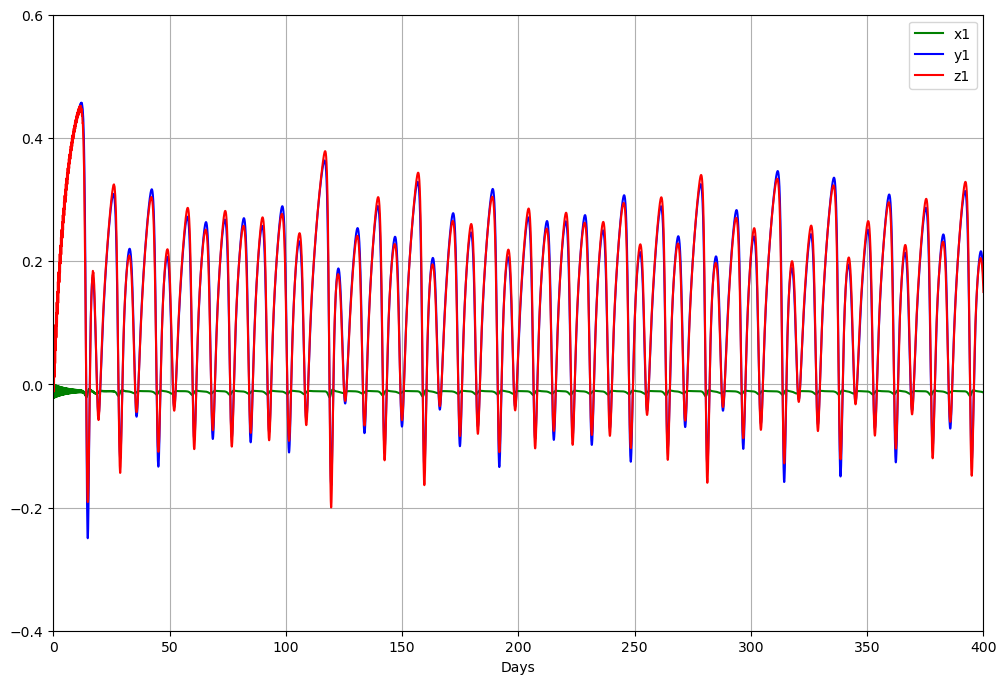

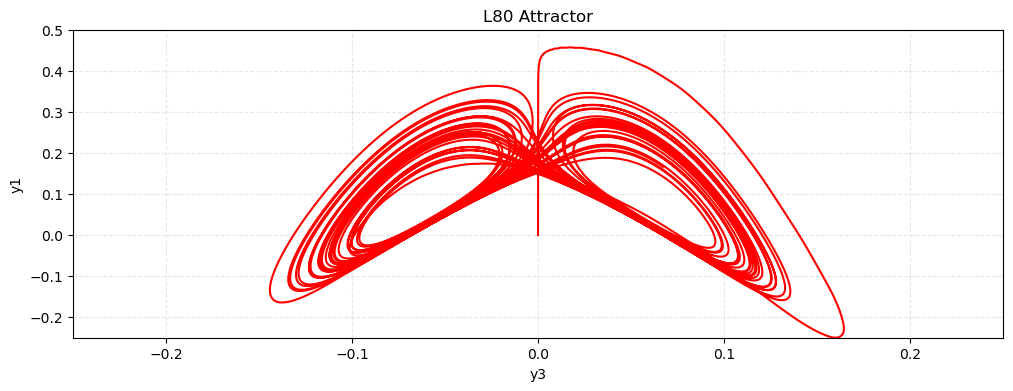

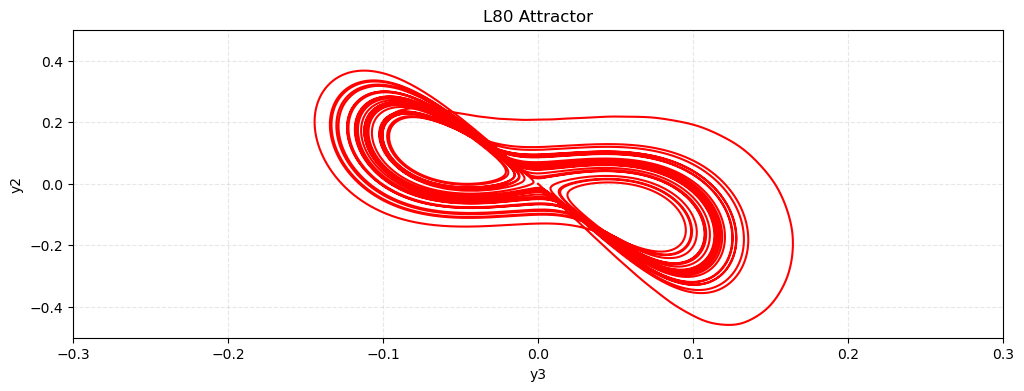

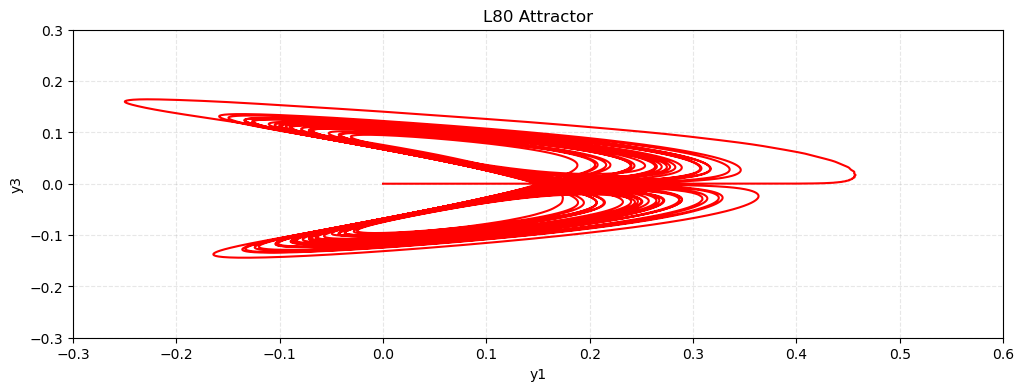

In [6]:
# SIMULATION HADLEY CONDITIONS 01

# Simulation days
hadley01_days = 400

# Initial conditions
y1 = (
    vector_f[1]
    / vector_a[1]
    * nu_0
    * (1 + vector_a[1] * g_0 + nu_0**2 * vector_a[1] ** 2)
)
z1 = (1 + nu_0**2 * vector_a[1] ** 2) * y1
x1 = -nu_0 * vector_a[1] * y1

hadley01_initial_x = [x1, 0, 0]
hadley01_initial_y = [y1, -(10 ** (-5)), 0]
hadley01_initial_z = [z1, 10 ** (-5), 0]

# PE model simulation
t_hadley01, x_hadley01, y_hadley01, z_hadley01 = runge_kutta_pe(
    hadley01_initial_x, hadley01_initial_y, hadley01_initial_z, hadley01_days
)

# Plot
evolution_x1y1z1(t_hadley01, x_hadley01, y_hadley01, z_hadley01, hadley01_days)
plot_y3y1(y_hadley01)
plot_y2y3(y_hadley01)
plot_y1y3(y_hadley01)
plt.show()

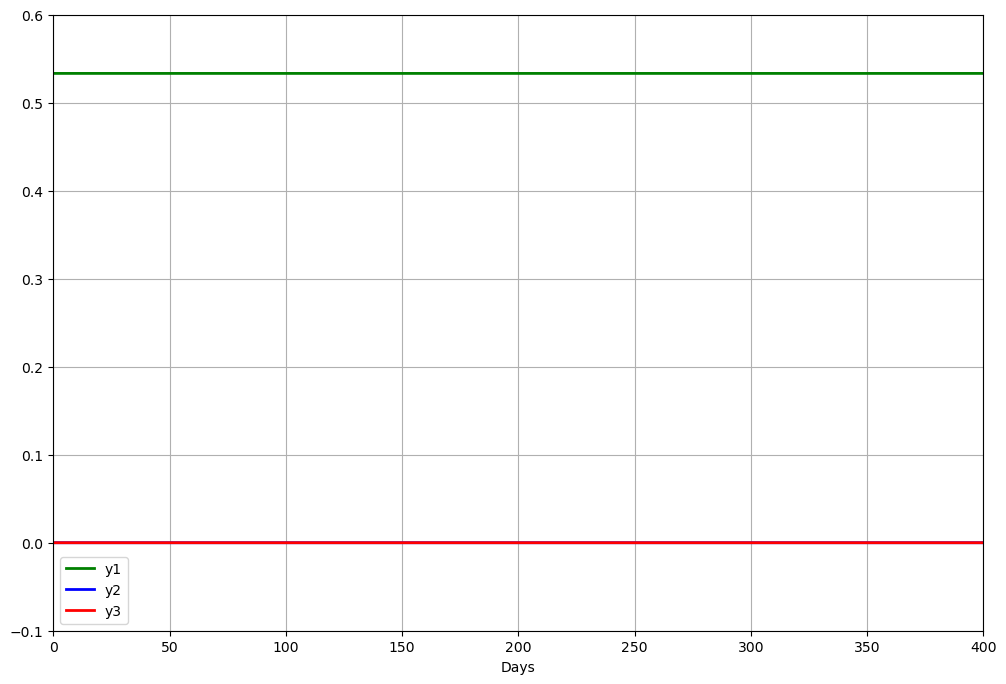

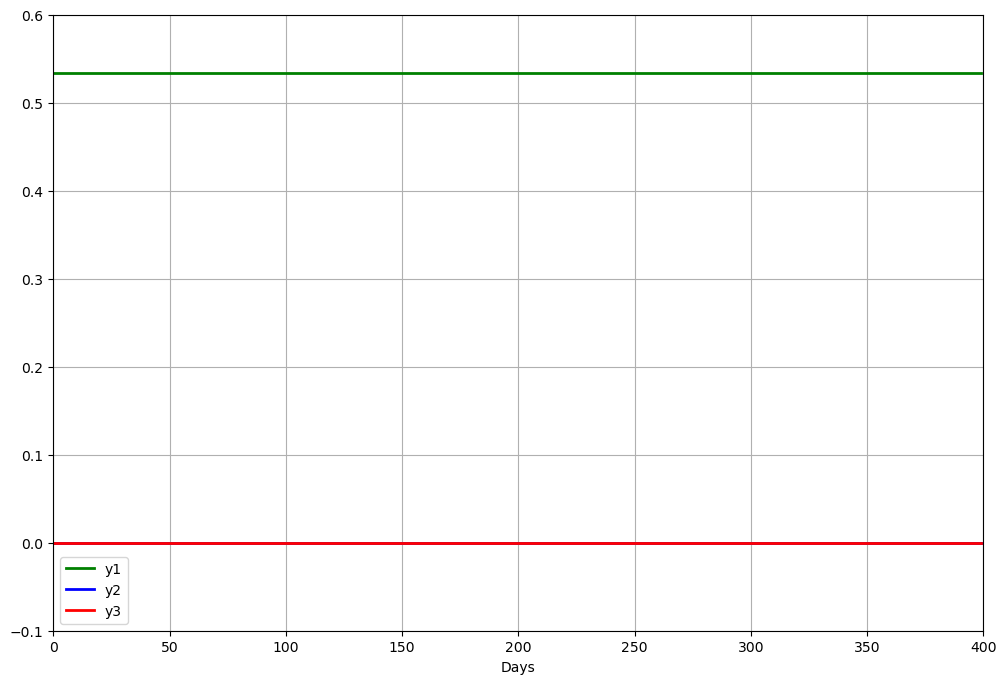

In [7]:
# SIMULATION HADLEY CONDITIONS 02

# Days of simulation
hadley02_days = 400

# Initial conditions of the PE model
hadley02_initial_x = [-0.01111, 0, 0]
hadley02_initial_y = [0.53331, 0, 0]
hadley02_initial_z = [0.53354, 0, 0]

# Initial conditions of the QG model
y0 = [0.53333, 0, 0]

# PE model simulation
t_hadley02, x_hadley02, y_hadley02, z_hadley02 = runge_kutta_pe(
    hadley02_initial_x, hadley02_initial_y, hadley02_initial_z, hadley02_days
)

# Simulation of the QG model
t0, sol0 = runge_kutta_qg(y0, hadley02_days)

# Plotting
plot_evolution_y(t_hadley02, y_hadley02, hadley02_days)
plot_evolution_y(t0, sol0, hadley02_days)
plt.show()

## 📚 References

[1] Lorenz, E. N. (1980). Attractor sets and quasi-geostrophic equilibrium. Journal of the Atmospheric Sciences, 37(8), 1685–1699. https://doi.org/10.1175/1520-0469(1980)037<1685:asaqge>2.0.co;2

[2] Roma, A. M., Bevilacqua, J. S., & Nós, R. L. (2023). Methods for the numerical solution of initial value ordinary differential equations [Lecture notes, Numerical Methods course, USP]. Unpublished material. (In portuguese)


[3] Chekroun, M. D., Liu, H., & McWilliams, J. C. (2017). The emergence of fast oscillations in a reduced primitive equation model and its implications for closure theories. Computers & Fluids, 151, 3–22. doi:10.1016/j.compfluid.2016.07.005

[4] Gent, P. R., & McWilliams, J. C. (1982). Intermediate model solutions to the Lorenz equations: Strange attractors and other phenomena. Journal of the Atmospheric Sciences, 39(1), 3–13. doi:10.1175/1520-0469(1982)039<0003:imsttl>2.0.co;2

_Translated with [DeepL- Free version](https://www.deepl.com)_